In [28]:
import hydra as hy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate

# Outlet Characterization
## Open Channel Flow in Culvert Sections - Section 1 and 2 Barrels
* At design and peak flows, flows will be in subcritical regime. 
* Discharge limited by section 2 capacity, pressurizes for flows > section 2 peak.

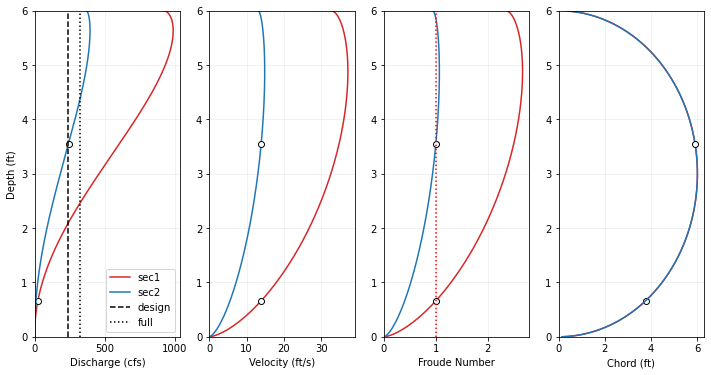

In [96]:
sec1 = hy.Section(300, 72/12)
sec2 = hy.Section(600, 72/12)
sec1.set_unpressurized_params(0.012, 0.04)
sec2.set_unpressurized_params(0.012, 0.0064)

sec1.calc_unpressurized()
sec2.calc_unpressurized()

fig, ax = plt.subplots(figsize=(12, 6), nrows=1, ncols=4)
ax = ax.flatten()
__, ax[0] = sec1.plot_unpressurized('Q', 'depths', ax=ax[0], c='tab:red', label='sec1')
__, ax[0] = sec2.plot_unpressurized('Q', 'depths', ax=ax[0], c='tab:blue', label='sec2')
__, ax[1] = sec1.plot_unpressurized('V', 'depths', ax=ax[1], c='tab:red')
__, ax[1] = sec2.plot_unpressurized('V', 'depths', ax=ax[1], c='tab:blue')
__, ax[2] = sec1.plot_unpressurized('Fr', 'depths', ax=ax[2], c='tab:red')
__, ax[2] = sec2.plot_unpressurized('Fr', 'depths', ax=ax[2], c='tab:blue')
__, ax[3] = sec1.plot_unpressurized('chord', 'depths', ax=ax[3], c='tab:red')
__, ax[3] = sec2.plot_unpressurized('chord', 'depths', ax=ax[3], c='tab:blue')
ax[0].plot([241,241],[0,6], 'k--', label='design')
ax[0].plot([326,326],[0,6], 'k:', label='full')
ax[0].legend()
ax[2].plot([1, 1],[0,6], 'r:', label='critical')
ax[0].set_ylabel('Depth (ft)')
x_labels = ['Discharge (cfs)', 'Velocity (ft/s)', 'Froude Number', 'Chord (ft)']
for i, a in enumerate(ax):
    a.set_xlabel(x_labels[i])
    a.grid(which='both', alpha=0.2)
    a.set_xlim(left=0)
    a.set_ylim(bottom=0, top=6)
plt.show()

## Culvert Section - Combined Unpressurized / Pressurized Flow
* Considers culvert-like sections (components downstream of shaft), section 1 and 2. 
* Downstream section 1 backs up around 412 cfs, expect pressurization upstream.
* Pressurized results model/idealize the shaft/drop inlet as an upstream resevoir.

Pressurized at Qmax: 412 cfs


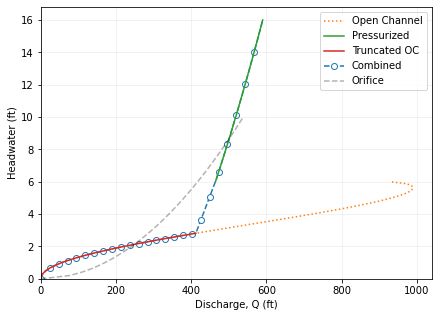

In [536]:
pf = hy.PressurizedFlow()

diam1, diam2 = 72/12, 72/12
length1, length2 = 292, 609
n = 0.012
slope1, slope2 = 0.04, 0.0075
C = 140
K1, K2 = 0.25, 1.25
el_1a, el_1b = 278.43 + diam1/2, 266.16
el_2a, el_2b = 266.16, 261.58 + diam2/2


sec1 = hy.Section(length1, diam1)
sec2 = hy.Section(length2, diam2)
sec1.set_unpressurized_params(n, slope1)
sec2.set_unpressurized_params(n, slope2)
sec1.set_pressurized_params(C, K1, el_1a, el_1b)
sec2.set_pressurized_params(C, K2, el_2a, el_2b)

# Compute rating curve
dH = 10
sections = [sec1, sec2]
system = hy.SectionComposite(sections)
rating1 = system.calc_rating_unpressurized(N=1000)
rating2 = system.calc_rating_pressurized(dH, N=1000)
rating_comb = system.rating_combined(N=1000)

fig, ax = plt.subplots(figsize=(7,5))

ax.plot(rating1.Q, rating1.headwater, ':',
        c='tab:orange', label='Open Channel')
ax.plot(rating2.Q, sec1.diam + rating2.heights,
        c='tab:green', label='Pressurized')

mask = rating1.Q <= system.pressurized_at()
ax.plot(rating1.Q[mask], rating1.headwater[mask],
        c='tab:red', label='Truncated OC')

ax.plot(rating_comb.Q, rating_comb.height,
        'o--', markevery=40, mfc='w', zorder=0,
        c='tab:blue', label='Combined')

# Add orifice calc
H = np.linspace(0, 10)
Q_or = hy.UnpressurizedFlow().Q_orifice(sec1.area, H, Cd=0.75)
ax.plot(Q_or, H, 'k--', alpha=0.3, label='Orifice')

plt.xlabel('Discharge, Q (ft)')
plt.ylabel('Headwater (ft)')
plt.xlim(left=0)
plt.ylim(bottom=0)
plt.grid(alpha=0.2, which='both')
plt.legend()
plt.show()

system.save_combined("Rating_CulvertSections_72in.csv")

## Composite Weir / Shaft Spillway
* Analyzing the weir, weir box, and shaft together as a composite, have adequate capacity for expected storm flow of 241 cfs.
* Does not overtop if diversion structure runs full to crown, but < 1.5 feet freeboard. 
* Increasing the drop inlet to 84 inch diameter is a possibility to ensure the composite stays completely weir controlled.
* At an 84 inch diameter, a transition at 400 cfs would still be able to be sustained by downstream components without pressurization. 

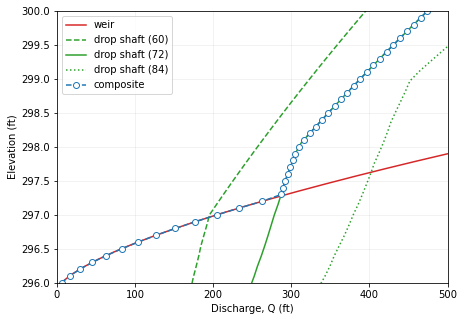

In [592]:
# Weir
dH_weir = 11
weir_length = 45
weir_height = 3.9
weir = hy.WeirFlow(weir_length, weir_height)
weir.calc_rating(dH_weir)

# Drop shafts (60 in, 72in, 84in)
dH_drop = 15
drop_shafts = {}
diams_inches = [60, 72, 84]
for size in diams_inches:
    drop = hy.ShaftFlow(size/12, 0)
    drop.calc_rating(dH_drop)
    drop_shafts[str(size)] = drop

# Composite weir/shaft
el_weir_crest = 295.9
el_drop_crest = 292

composites = {}
for size, drop in zip(drop_shafts.keys(), drop_shafts.values()):
    x = np.arange(el_weir_crest, 303, 0.1)
    f1 = interpolate.interp1d(el_weir_crest + weir.rating.height,
                              weir.rating.Q, bounds_error=False,
                              fill_value=(0,weir.rating.Q.max()))
    f2 = interpolate.interp1d(el_drop_crest + drop.rating.height,
                              drop.rating.Q, bounds_error=False,
                              fill_value=(0,drop.rating.Q.max()))
    df = pd.DataFrame(data={'Q':[min(x1,x2) for x1, x2 in zip(f1(x), f2(x))], 
                            'elev':x}).dropna()
    df.to_csv(f"Rating_WeirDropShaft_{size}in.csv")
    composites[size] = df


lstyles = ['--','-',':']
fig, ax = plt.subplots(figsize=(7,5))
plt.plot(weir.rating.Q, el_weir_crest + weir.rating.height, 
         c='tab:red', label='weir')
for i, (size, drop) in enumerate(zip(drop_shafts.keys(), drop_shafts.values())):
    plt.plot(drop.rating.Q, el_drop_crest + drop.rating.height, 
             lstyles[i], c='tab:green', label=f"drop shaft ({size})")
plt.plot(composites['72'].Q, composites['72'].elev, 
         'o--', c='tab:blue', mfc='w', label='composite')
plt.xlabel('Discharge, Q (ft)')
plt.ylabel('Elevation (ft)')
plt.xlim(left=0, right=500)
plt.ylim(bottom=296, top=300)
plt.grid(which='both', alpha=0.2)
plt.legend()
plt.show()

## Pressurized Flow in Shaft and Culvert Sections Combined
* Pressurized calculations consider pressurized flow through shaft and downstream culverts (tube-like) sections.
* Reference for pressurized calculations is the box bottom.
* Supposing that the system completely pressurizes, the capacity would still exceed be governed by the weir-drop inlet composite for the flow range of interest (< 400 cfs)

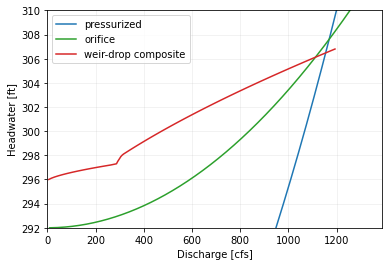

In [596]:
D = 72/12
L = 13 + 292 + 600
C = 140
K = 5
z1, z2 = 292, 261.58
Cd = 0.65
dH = 20

sec = hy.Section(length, diam)
sec.set_pressurized_params(C, K, z1, z2)

sec.calc_pressurized(dH)
sec.calc_orifice(A=sec.area,
                 Cd=Cd,
                 H_max=sec.rating_press['heights'].max())

fig, ax = plt.subplots()
ax.plot(sec.rating_press['Q'],
        sec.rating_press['heights'] + el_1, 
        c='tab:blue',
        label='pressurized') 
ax.plot(sec.rating_orifice['Q'],
        sec.rating_orifice['H'] + el_1, 
        c='tab:green',
        label='orifice')


x = np.arange(el_weir_crest, 310, 0.1)
f1 = interpolate.interp1d(el_weir_crest + weir.rating.height,
                          weir.rating.Q, bounds_error=False)
f2 = interpolate.interp1d(el_drop_crest + drop_shafts['72'].rating.height,
                          drop_shafts['72'].rating.Q, bounds_error=False)
df = pd.DataFrame(data={'Q':[min(x1,x2) for x1, x2 in zip(f1(x), f2(x))], 
                        'elev':x}).dropna()


ax.plot(df.Q, 
        df.elev, 
        c='tab:red',
        label='weir-drop composite')


plt.xlabel('Discharge [cfs]')
plt.ylabel('Headwater [ft]')
plt.xlim(left=0)
plt.ylim(bottom=el_1, top=310)
plt.grid(which='both', alpha=0.2)
ax.legend()
plt.show()

## Partial Submergence
* The effect of the partial submergence at the outfall would likely induce pressurization of the system in the upstream direction. 
* However, if the system pressurizes, the pressurized capacity is still sufficient to pass expected flows. Therefore the submergence is not expected to be an issue.

# Diversion Structure - Max Headwater
* What is the maximum acting headwater? 
* Assume the peak stormflow based on the DSOD hydrology gets distributed amongst the 3 diversion structures. 
* Calculate the normal depth under the peak stormflow to establish the maximum headwater. 
* Under these assumptions, maximum headwater ~ 5.5 ft.


* At the Legado Diversion, the mainline SD (Line C) is 102” diameter and has a slope of 1.3%
* At the Coyotes Diversion, the mainline SD (Line C3) is 78” diameter and has a slope of 1.0%
* At the Gibby Diversion, the mainline SD (Line F) is 120” diameter and has a slope of 1.0%

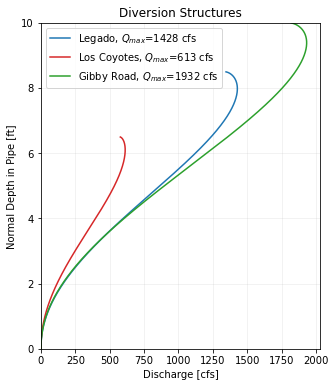

In [380]:
names = ['Legado', 'Los Coyotes', 'Gibby Road']
diams = [102/12, 78/12, 120/12]
slopes = [0.013, 0.01, 0.01]
n = 0.012
colors = ['tab:blue','tab:red','tab:green']

divs = {}
for i in range(len(diams)):
    div = hy.Section(None, diams[i])
    div.set_unpressurized_params(n, slopes[i])
    div.calc_unpressurized()
    divs[names[i]] = div
    
fig, ax = plt.subplots(figsize=(5,6))
for i, key in enumerate(divs.keys()):
    ax.plot(divs[key].rating_open.Q, divs[key].rating_open.depths, 
            label=f"{names[i]}, "+"$Q_{max}$"+f"={divs[key].rating_open.Q.max():.0f} cfs", 
            c=colors[i])
plt.title('Diversion Structures')
plt.legend(loc='upper left')
plt.ylim(0, div.diam)
plt.xlim(left=0)
plt.grid(which='both', alpha=0.2)
plt.xlabel('Discharge [cfs]')
plt.ylabel('Normal Depth in Pipe [ft]')
plt.show()

* If flow is diverted equally to the storm drains, then the capacity would exceed Lose Coyotes.
* If make proportional to storm drain size, results are inconsistent with consultant analyses. Gibby would pass largest flows based on capacity compared with Legado based on consultant analyses.
* Distributing by consultant analyses could be reasonable.
* Alternatively, can assume simplistically that flow is diverted equally amongst the storm drains, and that Legado is a representative storm drain.

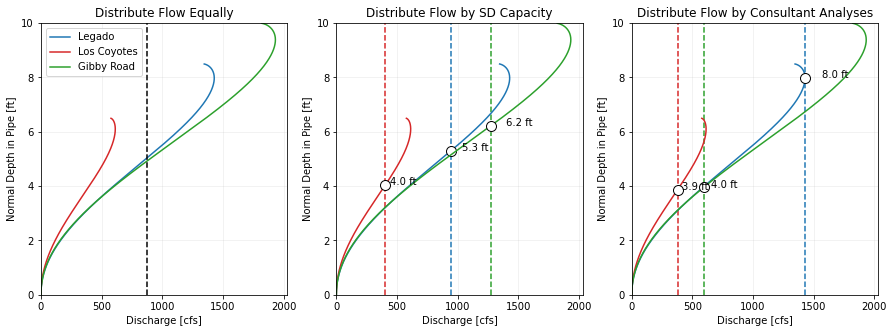

In [412]:
Qmax_cfs = 2622
N = 3
Qdiv_cfs = Qmax_cfs/N

wt_by_size = np.array([d.rating_open.Q.max() for d in divs.values()])
wt_by_size /= sum([d.rating_open.Q.max() for d in divs.values()])

wt_by_analyses = np.array([223, 51, 80])
wt_by_analyses = wt_by_analyses/sum(wt_by_analyses)

    
fig, ax = plt.subplots(ncols=3, figsize=(15,5))
ax = ax.flatten()
SD_max_normal_depths = []
for i, key in enumerate(divs.keys()):
    
    # Open channel flow curves
    ax[0].plot(divs[key].rating_open.Q, divs[key].rating_open.depths, c=colors[i], label=names[i])
    ax[1].plot(divs[key].rating_open.Q, divs[key].rating_open.depths, c=colors[i], label=names[i])
    ax[2].plot(divs[key].rating_open.Q, divs[key].rating_open.depths, c=colors[i], label=names[i])
    
    # By storm drain capacity
    idx = np.argmin(np.abs(divs[key].rating_open.Q - Qmax_cfs*wt_by_size[i]))
    ax[1].plot(divs[key].rating_open.Q[idx], divs[key].rating_open.depths[idx], 'ko', mfc='w', ms=10)
    ax[1].text(divs[key].rating_open.Q[idx]*1.1, divs[key].rating_open.depths[idx], f"{divs[key].rating_open.depths[idx]:.1f} ft")
    ax[1].plot(np.ones(2)*divs[key].rating_open.Q[idx], [0, 10], '--', c=colors[i], zorder=0)
    
    # By consultant analyses
    idx = np.argmin(np.abs(divs[key].rating_open.Q - Qmax_cfs*wt_by_analyses[i]))
    ax[2].plot(divs[key].rating_open.Q[idx], divs[key].rating_open.depths[idx], 'ko', mfc='w', ms=10)
    ax[2].text(divs[key].rating_open.Q[idx]*1.1, divs[key].rating_open.depths[idx], f"{divs[key].rating_open.depths[idx]:.1f} ft")
    ax[2].plot(np.ones(2)*divs[key].rating_open.Q[idx], [0, 10], '--', c=colors[i], zorder=0)
    
    # Save normal depths from consultant analyses
    SD_max_normal_depths.append(divs[key].rating_open.depths[idx])
    
ax[0].plot(np.ones(2)*Qdiv_cfs, [0, 10], '--', c='k')
ax[0].legend()
for a in ax:
    a.set_ylim([0, 10])
    a.set_xlim(left=0)
    a.grid(which='both', alpha=0.2)
    a.set_xlabel('Discharge [cfs]')
    a.set_ylabel('Normal Depth in Pipe [ft]')
ax[0].set_title('Distribute Flow Equally')
ax[1].set_title('Distribute Flow by SD Capacity')
ax[2].set_title('Distribute Flow by Consultant Analyses')
plt.show()

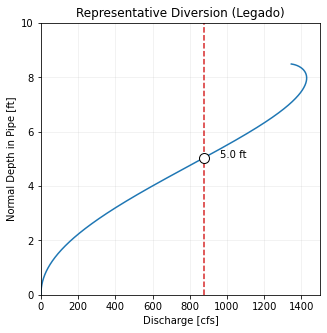

In [400]:
key = 'Legado'
fig, ax = plt.subplots(ncols=1, figsize=(5,5))

plt.plot(divs[key].rating_open.Q, divs[key].rating_open.depths, c='tab:blue')
plt.plot(np.ones(2)*Qdiv_cfs, [0, 10], '--', c='tab:red')

idx = np.argmin(np.abs(divs[key].rating_open.Q - Qdiv_cfs))
plt.plot(divs[key].rating_open.Q[idx], divs[key].rating_open.depths[idx], 'ko', mfc='w', ms=10)
plt.text(divs[key].rating_open.Q[idx]*1.1, divs[key].rating_open.depths[idx], f"{divs[key].rating_open.depths[idx]:.1f} ft")

plt.ylim([0, 10])
plt.xlim(left=0)
plt.grid(which='both', alpha=0.2)
plt.xlabel('Discharge [cfs]')
plt.ylabel('Normal Depth in Pipe [ft]')
plt.title('Representative Diversion (Legado)')
plt.show()

# Inflow Curves
* Inflow rating curves for diversion outlets based on headwaters in SD pipes using DSOD hydrology but proportional to consultant flows.

In [423]:
# Consultant inflow curves
div_c = {
    'Legado':pd.DataFrame(data={
        'elev':[311,310,309,308,307,306,305,304,303,302,301,300,299,298,297],
        'Q':[223,210,200,190,179,169,157,144,130,116,101,74,38,0,0]}), 
    'Los Coyotes':pd.DataFrame(data={
        'elev':[319,318,317,316,315,314,313,312,311,310,309,308.57],
        'Q':[51,50,49,48,47,46,45,44,42,33,5,0]}), 
    'Gibby Road':pd.DataFrame(data={
        'elev':[327,326,325,324,323,322,321,320,319,318,317,316,315,314,313,312.6],
        'Q':[80,79,78,77,76,75,74,73,72,71,70,68,57,29,3,0]})
}

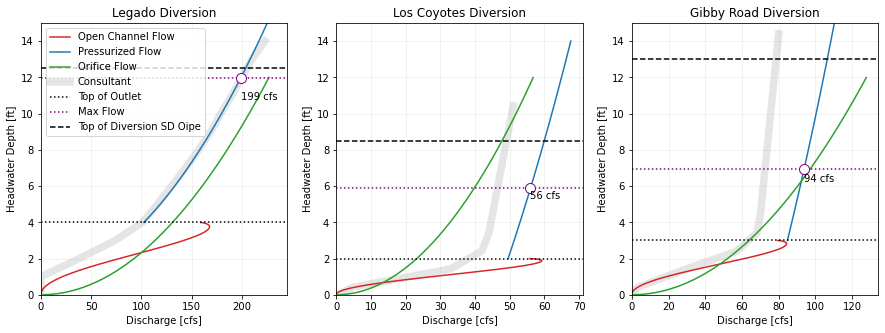

Max inflow (pressurized): 349 cfs
Max inflow (orifice): 364 cfs
Max inflow (combined): 380 cfs


In [488]:
names = ['Legado', 'Los Coyotes', 'Gibby Road']
diams = [4, 2, 3]
slopes = [0.01, 0.0502, 0.0117]
lengths = [300, 290, 1594]
z_us_invert = [297, 308.57, 312.6]
z_ds_invert = [294, 294, 294]
n = 0.012
C = 140
K = 1
Cds = [0.65, 0.65, 0.65]     # standard
#Cds = [0.55, 0.80, 0.75]    # to better match pressure curves


dH = 12
sections = {}
for i in range(len(names)):
    
    # Make sections
    s = hy.Section(lengths[i], diams[i])
    
    # Set parameters
    s.set_unpressurized_params(n, slopes[i])
    s.set_pressurized_params(C, K, z_us_invert[i], z_ds_invert[i])
    
    # Calculations
    s.calc_unpressurized()
    s.calc_pressurized(dH)
    s.calc_orifice(A=s.area,
                   Cd=Cds[i],
                   H_max=dH)
    # Save results
    sections[names[i]] = s


fig, ax = plt.subplots(ncols=3, nrows=1, figsize=(15,5))
ax = ax.flatten()
my_flows_p, my_flows_o = [], []
for i, key in enumerate(sections.keys()):
    
    # Flow regimes
    sections[key].rating_open = sections[key].rating_open.iloc[:-1,:]
    ax[i].plot(sections[key].rating_open.Q, sections[key].rating_open.depths, 
               label='Open Channel Flow', c='tab:red')
    ax[i].plot(sections[key].rating_press.Q, sections[key].rating_press.depths, 
               label='Pressurized Flow', c='tab:blue')
    ax[i].plot(sections[key].rating_orifice.Q, sections[key].rating_orifice.H, 
               label='Orifice Flow', c='tab:green') 
    
    # Consultant curves
    ax[i].plot(div_c[names[i]].Q, div_c[names[i]].elev - z_us_invert[i],
               '-', c='gray', lw=7.5, zorder=0, alpha=0.2, label='Consultant')
    
    # Styling
    ax[i].set_title(f"{key} Diversion")
    ax[i].grid(which='both', alpha=0.2)
    ax[i].set_ylim(bottom=0,top=15)
    ax[i].set_xlim(left=0)
    ax[i].set_xlabel('Discharge [cfs]')
    ax[i].set_ylabel('Headwater Depth [ft]')
    
    # Limits
    ax[i].plot( ax[i].get_xlim(), sections[key].diam*np.ones(2), 
               'k:', label='Top of Outlet')
    ax[i].plot( ax[i].get_xlim(), (sections[key].diam + SD_max_normal_depths[i])*np.ones(2),
               ':', c='purple', label='Max Flow')
    ax[i].plot( ax[i].get_xlim(), (sections[key].diam + divs[names[i]].diam)*np.ones(2),
               'k--', label='Top of Diversion SD Oipe')
    
    # Compute and add points on pressurized curves.
    idx = np.argmin(np.abs(sections[key].rating_press.depths - 
                           sections[key].diam - 
                           SD_max_normal_depths[i]))
    ax[i].plot(sections[key].rating_press.Q[idx], sections[key].rating_press.depths[idx],
               'o', c='purple', mfc='w', ms=10)
    ax[i].text(sections[key].rating_press.Q[idx], sections[key].rating_press.depths[idx]*0.9,
               f"{sections[key].rating_press.Q[idx]:.0f} cfs")
    my_flows_p.append(sections[key].rating_press.Q[idx])
    
    # Compute points for orifice as well.
    idx = np.argmin(np.abs(sections[key].rating_orifice.H -
                           sections[key].diam - 
                           SD_max_normal_depths[i]))
    my_flows_o.append(sections[key].rating_orifice.Q[idx])
ax[0].legend()
plt.show()

my_flows_c = [max(x1,x2) for x1, x2 in zip(my_flows_p, my_flows_o)]
print(f"Max inflow (pressurized): {sum(my_flows_p):.0f} cfs")
print(f"Max inflow (orifice): {sum(my_flows_o):.0f} cfs")
print(f"Max inflow (combined): {sum(my_flows_c):.0f} cfs")

# Final thoughts
* 349 cfs estimated compares with consultant's 356 max flow estimated. 

* Can they pass that?
    * Marginal for 72 shaft. Won't overtop, but won't pass freeboard. 
    * Need increase shaft capacity. 
    * If upsize to 84 shaft, will be weir-controlled. Downstream will still have adequate capacity, even if pressurized/submerged.